In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# ssl._create_default_https_context = ssl._create_unverified_context
def get_batch(size):
    index = np.random.randint(0, np.shape(X_train)[0], size)
    return X_train[index, :], Y_train[index]


tf.set_random_seed(1)
np.random.seed(1)

#50
BATCH_SIZE = 70
# LR = 0.001              # learning rate

imageBigDataORL = np.zeros((400, 112*92))
YBigData = np.zeros((400,1))

#read_in

for people in range(1,41):
    for face in range(1,11):
        path = './ORL/s%d_%d.bmp' % (people, face)
        oriImage = PIL.Image.open(path)
        imageArray = np.array(oriImage)
#             print(imageArray)
        imageVec = np.reshape(imageArray, imageArray.shape[0] * imageArray.shape[1])
        # print(imageArray.shape)
        # print(imageBigDataORL.shape)
#             print((people - 1) * 10 + face)
        imageBigDataORL[(people - 1) * 10 + face - 1] = imageVec
        YBigData[(people - 1) * 10 + face - 1] = people

# onehot and other pre-process


# print(imageBigDataORL)
# print(YBigData)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(YBigData)
Big_Y = enc.transform(YBigData).toarray()
# print(Big_Y)

# divide train and test
X_train, X_test, Y_train, Y_test = train_test_split(imageBigDataORL, Big_Y, test_size=0.3, random_state=50)

# plot one example

print(X_train.shape)     # (55000, 28 * 28)
print(Y_train.shape)   # (55000, 10)
plt.imshow(X_train[0].reshape((112, 92)), cmap='gray')
plt.title('%i' % (np.argmax(Y_train[0]) + 1)); plt.show()



(280, 10304)
(280, 40)


In [2]:
#define network_input

with tf.variable_scope('Inputs'):
    tf_x = tf.placeholder(tf.float32, [None, 112*92]) / 255.
    image = tf.reshape(tf_x, [-1, 112, 92, 1])              # (batch, height, width, channel)
    tf_y = tf.placeholder(tf.int32, [None, 40])            # input y

# CNN No.1
# with tf.variable_scope('Net'):
#     conv1 = tf.layers.conv2d(   # shape (112, 92, 1)
#         inputs=image,
#         filters=16,
#         kernel_size=4,
#         strides=1,
#         padding='same',
#         activation=tf.nn.relu,
#         name='conv_1'
#     )           # -> (112, 92, 16)
#     pool1 = tf.layers.max_pooling2d(
#         conv1,
#         pool_size=2,
#         strides=2,
#         name='pool1'
#     )           # -> (56, 46, 16)
#     conv2 = tf.layers.conv2d(pool1, 16, 2, 1, 'same', activation=tf.nn.relu, name='conv2')    # -> (56, 46, 16)
#     pool2 = tf.layers.max_pooling2d(conv2, 2, 2, name='pool2')    # -> (28, 23, 16)
#     flat = tf.reshape(pool2, [-1, 28*23*16], name='flatten')          # -> (28*23*16, )
#     output = tf.layers.dense(flat, 40,name='fully_connected')              # output layer


with tf.variable_scope('Net'):
    conv1 = tf.layers.conv2d(   # shape (112, 92, 1)
        inputs=image,
        filters=20,
        kernel_size=4,
        strides=1,
        padding='same',
        activation=tf.nn.relu,
        name='conv_1'
    )           # -> (112, 92, 20)
    pool1 = tf.layers.max_pooling2d(
        conv1,
        pool_size=2,
        strides=2,
        name='pool1'
    )           # -> (56, 46, 20)
    conv2 = tf.layers.conv2d(pool1, 40, 3, 1, 'same', activation=tf.nn.relu, name='conv2')    # -> (56, 46, 40)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2, name='pool2')    # -> (28, 23, 40)
    conv3 = tf.layers.conv2d(pool2, 60, 2, 1, 'same', activation=tf.nn.relu, name='conv3')    # -> (28, 23, 60)
    pool3 = tf.layers.max_pooling2d(conv3, 2, 2, name='pool3')    # -> (14, 12, 60)
    flat = tf.reshape(pool3, [-1, 14*11*60], name='flatten')          # -> (14*11*60, )
    output = tf.layers.dense(flat, 40,name='fully_connected')              # output layer
    
# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.0001
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.96, staircase=True)

# loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
# train_op = tf.train.AdamOptimizer(LR).minimize(loss)

global_step = tf.Variable(0, trainable=False)
#0.002
starter_learning_rate = 0.01
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.96, staircase=True)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)   # compute cost

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

tf.summary.scalar('loss', loss)     # add loss to scalar summary
tf.summary.scalar('acc', accuracy)

sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
sess.run(init_op)     # initialize var in graph

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')
def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 40)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
for step in range(1001):
    b_x, b_y = get_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    if step % 50 == 0:
        accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: X_test, tf_y: Y_test})
        print('Step:', step, '| train loss: %f' % loss_, '| test accuracy: %f' % accuracy_)

#         if HAS_SK:
#             # Visualization of trained flatten layer (T-SNE)
#             tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = Y_test.shape[0]
#             low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
#             labels = np.argmax(Y_test, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
    else:
        accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: X_test, tf_y: Y_test})
        print('Step:', step, '| train loss: %f' % loss_, '| test accuracy: %f' % accuracy_)
plt.ioff()

# # print 10 predictions from test data
# test_output = sess.run(output, {tf_x: test_x[:10]})
# pred_y = np.argmax(test_output, 1)
# print(pred_y, 'prediction number')
# print(np.argmax(test_y[:10], 1), 'real number')

Step: 0 | train loss: 31.155779 | test accuracy: 0.016667
Step: 1 | train loss: 222.441757 | test accuracy: 0.025000
Step: 2 | train loss: 117.342995 | test accuracy: 0.027778
Step: 3 | train loss: 24.367971 | test accuracy: 0.037500
Step: 4 | train loss: 11.911387 | test accuracy: 0.043333
Step: 5 | train loss: 7.683240 | test accuracy: 0.040278
Step: 6 | train loss: 6.322004 | test accuracy: 0.041667
Step: 7 | train loss: 4.110286 | test accuracy: 0.044792
Step: 8 | train loss: 3.816181 | test accuracy: 0.042593
Step: 9 | train loss: 3.982955 | test accuracy: 0.043333
Step: 10 | train loss: 3.551394 | test accuracy: 0.044697
Step: 11 | train loss: 3.549396 | test accuracy: 0.044444
Step: 12 | train loss: 3.466455 | test accuracy: 0.045513
Step: 13 | train loss: 3.503988 | test accuracy: 0.045833
Step: 14 | train loss: 3.445217 | test accuracy: 0.043889
Step: 15 | train loss: 3.126629 | test accuracy: 0.047396
Step: 16 | train loss: 3.020970 | test accuracy: 0.052451
Step: 17 | train 

Step: 141 | train loss: 0.000007 | test accuracy: 0.803639
Step: 142 | train loss: 0.000007 | test accuracy: 0.804720
Step: 143 | train loss: 0.000007 | test accuracy: 0.805787
Step: 144 | train loss: 0.000016 | test accuracy: 0.806839
Step: 145 | train loss: 0.000006 | test accuracy: 0.807877
Step: 146 | train loss: 0.000007 | test accuracy: 0.808900
Step: 147 | train loss: 0.000004 | test accuracy: 0.809910
Step: 148 | train loss: 0.000004 | test accuracy: 0.810906
Step: 149 | train loss: 0.000013 | test accuracy: 0.811889
Step: 150 | train loss: 0.000005 | test accuracy: 0.812859
Step: 151 | train loss: 0.000006 | test accuracy: 0.813816
Step: 152 | train loss: 0.000012 | test accuracy: 0.814760
Step: 153 | train loss: 0.000013 | test accuracy: 0.815693
Step: 154 | train loss: 0.000004 | test accuracy: 0.816613
Step: 155 | train loss: 0.000012 | test accuracy: 0.817521
Step: 156 | train loss: 0.000007 | test accuracy: 0.818418
Step: 157 | train loss: 0.000008 | test accuracy: 0.8193

Step: 280 | train loss: 0.000002 | test accuracy: 0.880160
Step: 281 | train loss: 0.000003 | test accuracy: 0.880437
Step: 282 | train loss: 0.000005 | test accuracy: 0.880713
Step: 283 | train loss: 0.000006 | test accuracy: 0.880986
Step: 284 | train loss: 0.000004 | test accuracy: 0.881257
Step: 285 | train loss: 0.000004 | test accuracy: 0.881527
Step: 286 | train loss: 0.000002 | test accuracy: 0.881794
Step: 287 | train loss: 0.000003 | test accuracy: 0.882060
Step: 288 | train loss: 0.000003 | test accuracy: 0.882324
Step: 289 | train loss: 0.000002 | test accuracy: 0.882586
Step: 290 | train loss: 0.000003 | test accuracy: 0.882847
Step: 291 | train loss: 0.000003 | test accuracy: 0.883105
Step: 292 | train loss: 0.000004 | test accuracy: 0.883362
Step: 293 | train loss: 0.000001 | test accuracy: 0.883617
Step: 294 | train loss: 0.000002 | test accuracy: 0.883870
Step: 295 | train loss: 0.000004 | test accuracy: 0.884122
Step: 296 | train loss: 0.000002 | test accuracy: 0.8843

Step: 419 | train loss: 0.000003 | test accuracy: 0.906032
Step: 420 | train loss: 0.000004 | test accuracy: 0.906156
Step: 421 | train loss: 0.000006 | test accuracy: 0.906280
Step: 422 | train loss: 0.000003 | test accuracy: 0.906403
Step: 423 | train loss: 0.000002 | test accuracy: 0.906525
Step: 424 | train loss: 0.000002 | test accuracy: 0.906647
Step: 425 | train loss: 0.000004 | test accuracy: 0.906768
Step: 426 | train loss: 0.000004 | test accuracy: 0.906889
Step: 427 | train loss: 0.000003 | test accuracy: 0.907009
Step: 428 | train loss: 0.000003 | test accuracy: 0.907129
Step: 429 | train loss: 0.000001 | test accuracy: 0.907248
Step: 430 | train loss: 0.000003 | test accuracy: 0.907367
Step: 431 | train loss: 0.000003 | test accuracy: 0.907485
Step: 432 | train loss: 0.000001 | test accuracy: 0.907602
Step: 433 | train loss: 0.000003 | test accuracy: 0.907719
Step: 434 | train loss: 0.000002 | test accuracy: 0.907835
Step: 435 | train loss: 0.000002 | test accuracy: 0.9079

Step: 558 | train loss: 0.000003 | test accuracy: 0.919037
Step: 559 | train loss: 0.000002 | test accuracy: 0.919107
Step: 560 | train loss: 0.000001 | test accuracy: 0.919177
Step: 561 | train loss: 0.000002 | test accuracy: 0.919247
Step: 562 | train loss: 0.000001 | test accuracy: 0.919316
Step: 563 | train loss: 0.000001 | test accuracy: 0.919385
Step: 564 | train loss: 0.000002 | test accuracy: 0.919454
Step: 565 | train loss: 0.000003 | test accuracy: 0.919523
Step: 566 | train loss: 0.000002 | test accuracy: 0.919591
Step: 567 | train loss: 0.000004 | test accuracy: 0.919660
Step: 568 | train loss: 0.000002 | test accuracy: 0.919728
Step: 569 | train loss: 0.000002 | test accuracy: 0.919795
Step: 570 | train loss: 0.000001 | test accuracy: 0.919863
Step: 571 | train loss: 0.000003 | test accuracy: 0.919930
Step: 572 | train loss: 0.000002 | test accuracy: 0.919997
Step: 573 | train loss: 0.000001 | test accuracy: 0.920064
Step: 574 | train loss: 0.000002 | test accuracy: 0.9201

Step: 697 | train loss: 0.000001 | test accuracy: 0.926862
Step: 698 | train loss: 0.000001 | test accuracy: 0.926907
Step: 699 | train loss: 0.000002 | test accuracy: 0.926952
Step: 700 | train loss: 0.000001 | test accuracy: 0.926997
Step: 701 | train loss: 0.000002 | test accuracy: 0.927042
Step: 702 | train loss: 0.000001 | test accuracy: 0.927086
Step: 703 | train loss: 0.000002 | test accuracy: 0.927131
Step: 704 | train loss: 0.000002 | test accuracy: 0.927175
Step: 705 | train loss: 0.000001 | test accuracy: 0.927219
Step: 706 | train loss: 0.000002 | test accuracy: 0.927263
Step: 707 | train loss: 0.000001 | test accuracy: 0.927307
Step: 708 | train loss: 0.000001 | test accuracy: 0.927351
Step: 709 | train loss: 0.000002 | test accuracy: 0.927394
Step: 710 | train loss: 0.000001 | test accuracy: 0.927438
Step: 711 | train loss: 0.000001 | test accuracy: 0.927481
Step: 712 | train loss: 0.000001 | test accuracy: 0.927525
Step: 713 | train loss: 0.000001 | test accuracy: 0.9275

Step: 836 | train loss: 0.000002 | test accuracy: 0.932089
Step: 837 | train loss: 0.000001 | test accuracy: 0.932120
Step: 838 | train loss: 0.000001 | test accuracy: 0.932151
Step: 839 | train loss: 0.000001 | test accuracy: 0.932183
Step: 840 | train loss: 0.000001 | test accuracy: 0.932214
Step: 841 | train loss: 0.000001 | test accuracy: 0.932245
Step: 842 | train loss: 0.000001 | test accuracy: 0.932276
Step: 843 | train loss: 0.000001 | test accuracy: 0.932306
Step: 844 | train loss: 0.000001 | test accuracy: 0.932337
Step: 845 | train loss: 0.000001 | test accuracy: 0.932368
Step: 846 | train loss: 0.000001 | test accuracy: 0.932399
Step: 847 | train loss: 0.000001 | test accuracy: 0.932429
Step: 848 | train loss: 0.000001 | test accuracy: 0.932460
Step: 849 | train loss: 0.000002 | test accuracy: 0.932490
Step: 850 | train loss: 0.000001 | test accuracy: 0.932521
Step: 851 | train loss: 0.000001 | test accuracy: 0.932551
Step: 852 | train loss: 0.000002 | test accuracy: 0.9325

Step: 975 | train loss: 0.000001 | test accuracy: 0.935826
Step: 976 | train loss: 0.000001 | test accuracy: 0.935850
Step: 977 | train loss: 0.000001 | test accuracy: 0.935873
Step: 978 | train loss: 0.000001 | test accuracy: 0.935895
Step: 979 | train loss: 0.000001 | test accuracy: 0.935918
Step: 980 | train loss: 0.000000 | test accuracy: 0.935941
Step: 981 | train loss: 0.000001 | test accuracy: 0.935964
Step: 982 | train loss: 0.000002 | test accuracy: 0.935987
Step: 983 | train loss: 0.000001 | test accuracy: 0.936009
Step: 984 | train loss: 0.000001 | test accuracy: 0.936032
Step: 985 | train loss: 0.000001 | test accuracy: 0.936055
Step: 986 | train loss: 0.000001 | test accuracy: 0.936077
Step: 987 | train loss: 0.000001 | test accuracy: 0.936100
Step: 988 | train loss: 0.000001 | test accuracy: 0.936122
Step: 989 | train loss: 0.000001 | test accuracy: 0.936145
Step: 990 | train loss: 0.000001 | test accuracy: 0.936167
Step: 991 | train loss: 0.000001 | test accuracy: 0.9361

Step: 1000 | train loss: 0.000001 | test accuracy: 0.936432


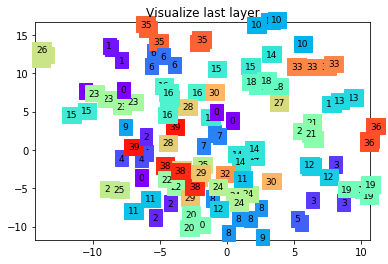

In [5]:
accuracy_, flat_representation, output_y = sess.run([accuracy, flat,output], {tf_x: X_test, tf_y: Y_test})
print('Step:', step, '| train loss: %f' % loss_, '| test accuracy: %f' % accuracy_)

if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = Y_test.shape[0]
    low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
    labels = np.argmax(Y_test, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)

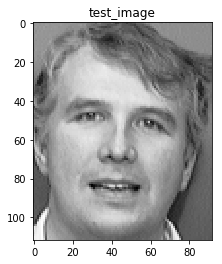

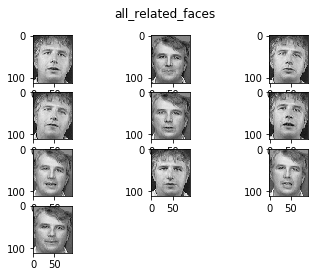

In [7]:
predictions=tf.argmax(output_y, axis=1)
acc, pred, onehot_predictions = sess.run([accuracy, output,predictions], {tf_x: X_test, tf_y: Y_test})
test_people = 0
face = X_test[test_people,:]
face_reshaped = np.reshape(face, [112, 92])
plt.figure()
plt.title('test_image')
plt.imshow(face_reshaped,cmap='Greys_r')
person = onehot_predictions[test_people]
plt.figure()
plt.suptitle('all_related_faces')
for faceNumber in range(1,11):
    path = './ORL/s%d_%d.bmp' % (person + 1, faceNumber)
    oriImage = PIL.Image.open(path)
    imageArray = np.array(oriImage)
    plt.subplot(4,3,faceNumber)
    plt.imshow(imageArray,cmap='Greys_r')